In [1]:
%config Completer.use_jedi = False

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import RDLogger, DataStructs, Chem
from rdkit.Chem import AllChem, Lipinski, rdFMCS, Descriptors, Draw
import rdkit.Chem.rdFreeSASA as FreeSASA
from tqdm import tqdm

# Gather clusters info and ligand assigned

In [2]:
astex = pd.read_csv('../data/astex_selected_for_docking.csv', usecols=['UniProt_ID', 'PDB', 'Lig', 'Smiles_String'])
astex['Template'] = astex.PDB + '_' + astex.Lig
astex = astex.drop(columns=['PDB', 'Lig'])
astex = astex[astex.UniProt_ID != 'P04818']

astex['Mol'] = astex.Smiles_String.apply(Chem.MolFromSmiles)
astex = astex.dropna().reset_index(drop=True)
astex

[16:25:48] Explicit valence for atom # 7 Cl, 5, is greater than permitted
[16:25:49] Explicit valence for atom # 35 O, 2, is greater than permitted


,UniProt_ID,Smiles_String,Template,Mol
0,O14757,c1cc(cnc1)c2cnc(s2)Nc3cc(ccn3)N4CCN(CC4)CC(=O)...,3TKH_07S,<rdkit.Chem.rdchem.Mol object at 0x7246a169c970>
1,O14757,COc1ccc2c(c1)C(=O)N(C2)c3nc(cs3)C(=O)Nc4cnccc4...,4HYH_1AM,<rdkit.Chem.rdchem.Mol object at 0x7246a169c9e0>
2,O14757,c1ccc2c(c1)cnn2c3nc(cs3)C(=O)Nc4ccccc4N5CCNCC5,4HYI_1AO,<rdkit.Chem.rdchem.Mol object at 0x7246a169ca50>
3,O14757,c1cc(ccc1c2cn3c(n2)c(cnc3C(=O)N)N[C@H]4CCCNC4)Cl,4JIK_1KO,<rdkit.Chem.rdchem.Mol object at 0x7246a169cac0>
4,O14757,Cn1cc(cn1)c2cnn3c2nc(c(c3N)Br)[C@@H]4CCC[C@@H]...,3OT3_22K,<rdkit.Chem.rdchem.Mol object at 0x7246a169cb30>
...,...,...,...,...
2002,Q8I3X4,CSC[C@@H]1[C@H]([C@H]([C@@H]([NH2+]1)c2c[nH]c3...,1Q1G_MTI,<rdkit.Chem.rdchem.Mol object at 0x7246a162fd10>
2003,Q9GPQ4,c1cnc(c2c1n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3)C...,1HP0_AD3,<rdkit.Chem.rdchem.Mol object at 0x7246a162fd80>
2004,Q9GPQ4,c1c(c2c([nH]1)c(ncn2)O)[C@H]3[C@@H]([C@@H]([C@...,3B9G_IMH,<rdkit.Chem.rdchem.Mol object at 0x7246a162fdf0>
2005,Q9GPQ4,c1cc2cccnc2c(c1)C[N@]3C[C@@H]([C@@H]([C@H]3CO)O)O,3EPX_IMQ,<rdkit.Chem.rdchem.Mol object at 0x7246a162fe60>


In [3]:
results = []


uniprots = astex.UniProt_ID.unique()

for uni in uniprots:
    clusters = [i for i in os.listdir(f'../clusters_analysis/{uni}/')
                if os.path.isdir(f'../clusters_analysis/{uni}/{i}/')]
    
    for cluster in clusters:
        with open(f'../clusters_analysis/{uni}/{cluster}/Matches_Smiles_Ligand_Name.txt', 'r') as f:
            for line in f:
                results.append({'UniProt_ID': uni,
                                'Cluster': cluster,
                                'Ligand': line.split('  ')[1][:-1]})

df = pd.DataFrame(results)

In [4]:
# 1. Number of ligands per cluster per UniProt_ID
ligands_per_cluster = df.groupby(['UniProt_ID', 'Cluster'])['Ligand'].nunique().reset_index(name='Num_Ligands')

# 2. Average, min, max ligands per cluster per UniProt_ID
cluster_stats = ligands_per_cluster.groupby('UniProt_ID')['Num_Ligands'].agg(['mean', 'min', 'max']).reset_index()
cluster_stats.columns = ['UniProt_ID', 'Avg_Ligands', 'Min_Ligands', 'Max_Ligands']

# 3. Ligand coverage: how many ligands in clusters vs Astex (per UniProt_ID)
# Total ligands per UniProt_ID in clustered df
ligands_per_target = df.groupby('UniProt_ID')['Ligand'].nunique().reset_index(name='Ligands_in_Clusters')

# Total ligands per UniProt_ID in Astex dataset
ligands_per_target_astex = astex.groupby('UniProt_ID')['Template'].nunique().reset_index(name='Ligands_in_Astex')

# Merge and compute coverage
ligand_coverage = pd.merge(
    ligands_per_target_astex,
    ligands_per_target,
    on='UniProt_ID',
    how='left'
)

ligand_coverage['Ligands_in_Clusters'] = ligand_coverage['Ligands_in_Clusters'].fillna(0).astype(int)
ligand_coverage['Coverage_%'] = 100 * ligand_coverage['Ligands_in_Clusters'] / ligand_coverage['Ligands_in_Astex']
ligand_coverage['Coverage_%'] = ligand_coverage['Coverage_%'].fillna(0)


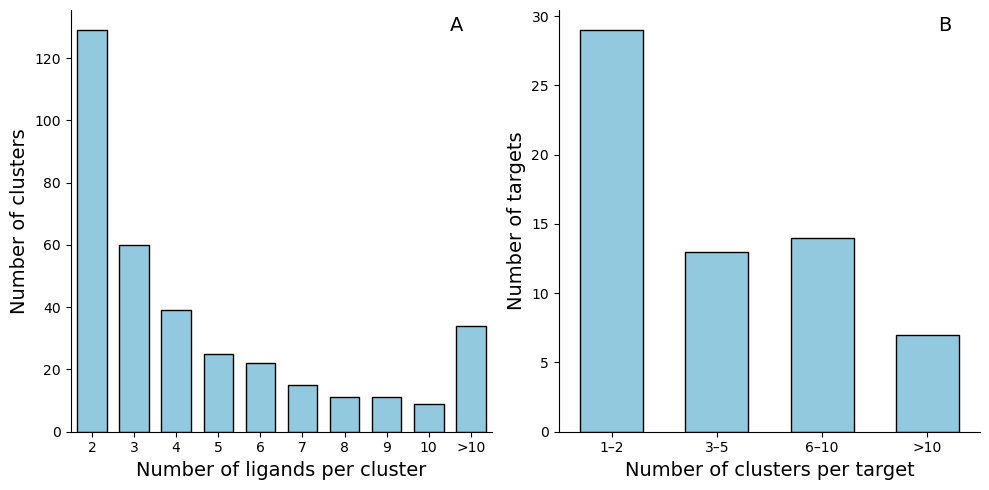

In [5]:
# First plot: Ligands per cluster
bins_lig = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
labels_lig = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']
ligands_per_cluster['Ligand_Bin'] = pd.cut(ligands_per_cluster['Num_Ligands'], bins=bins_lig, labels=labels_lig, right=True)
bin_counts_lig = ligands_per_cluster['Ligand_Bin'].value_counts().sort_index()

# Second plot: Clusters per UniProt_ID
clusters_per_uniprot = ligands_per_cluster.groupby('UniProt_ID')['Cluster'].nunique().reset_index(name='Num_Clusters')
bins_clu = [0, 2, 5, 10, np.inf]
labels_clu = ['1–2', '3–5', '6–10', '>10']
clusters_per_uniprot['Cluster_Bin'] = pd.cut(clusters_per_uniprot['Num_Clusters'], bins=bins_clu, labels=labels_clu, right=True)
bin_counts_clu = clusters_per_uniprot['Cluster_Bin'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(ax=axes[0], x=bin_counts_lig.index, y=bin_counts_lig.values, width=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Number of ligands per cluster', fontsize=14)
axes[0].set_ylabel('Number of clusters', fontsize=14)
axes[0].text(0.9, 0.95, 'A', transform=axes[0].transAxes, fontsize=14)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

sns.barplot(ax=axes[1], x=bin_counts_clu.index, y=bin_counts_clu.values, width=0.6, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Number of clusters per target', fontsize=14)
axes[1].set_ylabel('Number of targets', fontsize=14)
axes[1].text(0.9, 0.95, 'B', transform=axes[1].transAxes, fontsize=14)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('../images/clusters_statistics.png', dpi=300)
plt.show()


In [6]:
# ==== PRINT RESULTS ====
print(f"Number of targets in total: {len(df.drop_duplicates(subset=['UniProt_ID']))}\n")
print(f"Number of clusters in total: {len(df.drop_duplicates(subset=['UniProt_ID', 'Cluster']))}\n")

# 1. Ligands per cluster per UniProt_ID
print("Number of ligands per cluster per UniProt_ID:")
print(ligands_per_cluster.Num_Ligands.describe())


Number of targets in total: 63

Number of clusters in total: 355

Number of ligands per cluster per UniProt_ID:
count    355.000000
mean       5.312676
std        6.131399
min        2.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       60.000000
Name: Num_Ligands, dtype: float64


In [8]:
for i, uni, clus in ligands_per_cluster[['UniProt_ID', 'Cluster']].itertuples():
    
    mcs_df = pd.read_csv(f'../clustering_output/{uni}/{uni}_MCS_dict.csv')
    ligands_per_cluster.at[i, 'cluster_mcs'] = mcs_df[clus][2]
    ligands_per_cluster.at[i, 'ligands_list'] = list(df[(df['UniProt_ID'] == uni) & 
                                                   (df['Cluster'] == clus)].Ligand)
    
ligands_per_cluster

,UniProt_ID,Cluster,Num_Ligands,Ligand_Bin,cluster_mcs,ligands_list
0,O14757,104,3,3,"[#6]1:[#6]:[#6](:[#6]:[#6](:[#6]:1)-[#8,#6])-[...","[5OPV_A3H, 5OPU_A3K, 5OPS_A3Q]"
1,O14757,107,8,8,"[#6](:[#6]:[#6]:,-[#6]-,:[#6]:[#6]:[#6]-,:[#6]...","[3PA3_C70, 3PA4_C72, 3PA5_C73, 6FC8_D4Q, 6FCK_..."
2,O14757,110,2,2,[#6]-[#7]1:[#6]:[#6](:[#6]:[#7]:1)-[#6]1:[#6]:...,"[3OT3_22K, 3OT8_MI5]"
3,O14757,113,8,8,"[#6,#7]1:[#7,#6]:[#6]2:[#6](:[#7]:1):[#7]:[#6]...","[5OP5_3FE, 2YM4_4YM, 2YM3_YM3, 2YM5_YM5, 2YM6_..."
4,O14757,114,2,2,[#6]-[#7]-[#6]1:[#6](:[#6]:[#7]:[#6](:[#7]:1)-...,"[5OQ5_4K4, 5OP4_A0T]"
...,...,...,...,...,...,...
350,Q24451,55,9,9,"[#6]1-[#6]-[#6]-[#16,#7]2-[#6](-[#6]-1)-[#6](-...","[3EJP_HN2, 3EJQ_HN3, 3EJR_HN4, 3EJS_HN5, 3EJT_..."
351,Q54276,7,4,4,[#6]1-[#6]-[#6]2-[#7](-[#6]-1)-[#6](-[#6]-[#7]...,"[1W1V_ALJ, 1W1T_CHQ, 1W1P_GIO, 1W1Y_TYP]"
352,Q79MP6,2,2,2,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6](-...,"[1JJT_BDS, 1JJE_BYS]"
353,Q8I3X4,4,3,3,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...,"[6AQS_IM5, 1NW4_IMH, 1Q1G_MTI]"


In [93]:
ligands_per_cluster.to_csv('../clustering_output/ligands_in_clusters.csv', index=False)

In [9]:
ligands_per_cluster.groupby('UniProt_ID').size().describe()

count    63.000000
mean      5.634921
std       8.474443
min       1.000000
25%       1.000000
50%       3.000000
75%       7.000000
max      58.000000
dtype: float64

In [10]:
clusters_per_uniprot = ligands_per_cluster.groupby('UniProt_ID')['Cluster'].nunique().reset_index(name='number_of_clusters')

# Merge into astex summary table
ligands_per_target_astex = ligands_per_target_astex.merge(clusters_per_uniprot, on='UniProt_ID', how='left')

# Fill NaNs (in case some targets had no clusters at all)
ligands_per_target_astex['number_of_clusters'] = ligands_per_target_astex['number_of_clusters'].fillna(0).astype(int)

ligands_per_target_astex

,UniProt_ID,Ligands_in_Astex,number_of_clusters
0,O14757,73,16
1,O43570,12,3
2,O76074,17,3
3,P00183,3,0
4,P00374,22,6
...,...,...,...
66,Q24451,30,5
67,Q54276,5,1
68,Q79MP6,2,1
69,Q8I3X4,3,1


In [11]:
ligands_per_target_astex.sort_values(by='Ligands_in_Astex')

,UniProt_ID,Ligands_in_Astex,number_of_clusters
30,P10828,2,1
29,P10721,2,1
33,P13922,2,0
63,Q07785,2,0
48,P35557,2,1
...,...,...,...
6,P00734,116,21
42,P24941,128,22
25,P07900,143,23
47,P29476,200,10


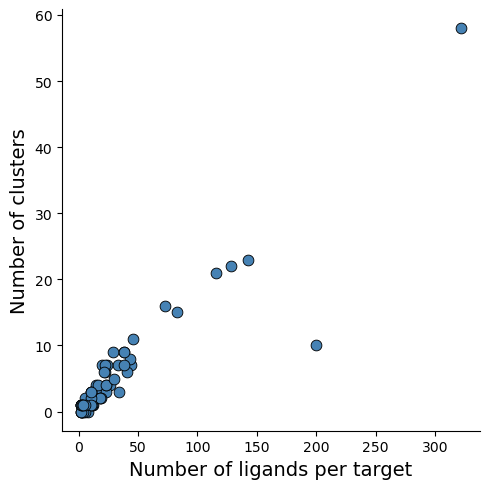

In [12]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=ligands_per_target_astex,
    x='Ligands_in_Astex',
    y='number_of_clusters',
    s=60, color='steelblue', edgecolor='black'
)

plt.xlabel('Number of ligands per target', fontsize=14)
plt.ylabel('Number of clusters', fontsize=14)

# Optional grid and layout tweaks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# plt.savefig('../images/number_cluster_number_ligands.png', dpi=300)

plt.show()

In [13]:
print(f'Ligand coverage stats:\n{ligand_coverage["Coverage_%"].describe()}')


Ligand coverage stats:
count     71.000000
mean      77.108851
std       30.124093
min        0.000000
25%       75.000000
50%       86.956522
75%       96.526104
max      100.000000
Name: Coverage_%, dtype: float64


In [14]:
print(f'Number of ligands in clusters: {ligand_coverage.Ligands_in_Clusters.sum()}')
print(f'Total ligands in the Astex set: {ligand_coverage.Ligands_in_Astex.sum()}')

Number of ligands in clusters: 1703
Total ligands in the Astex set: 2007


In [15]:
top_clusters_per_target = ligands_per_cluster.sort_values(['UniProt_ID', 'Num_Ligands'], ascending=[True, False])
top_clusters_per_target = top_clusters_per_target.groupby('UniProt_ID').head(1).reset_index(drop=True)

top_clusters_per_target

,UniProt_ID,Cluster,Num_Ligands,Ligand_Bin,cluster_mcs,ligands_list
0,O14757,132,9,9,"[#6]-[#6,#7]1:[#6]:[#6]2:[#7,#6]:[#7,#6]:[#6,#...","[2QHN_582, 1NVR_STU, 2YER_TQ1, 1NVS_UCM, 1NVQ_..."
1,O43570,19,5,5,[#6]-[#6]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6](...,"[5MSB_V13, 4Q0L_V14, 4QJO_V1F, 4QJW_WWO, 4QJ0_..."
2,O76074,26,10,10,"[#6,#7]1:[#6]:[#6](=[#8]):[#7]:[#6](:[#7]:1)-[...","[2CHM_3P4, 4I9Z_5BA, 4IA0_5BB, 3SIE_5BO, 3SHZ_..."
3,P00374,36,7,7,"[#6]-[#16,#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:...","[3NU0_3TU, 3NTZ_3TZ, 1DRF_FOL, 3GHC_GHC, 3GHW_..."
4,P00520,7,4,4,"[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#7,#6]...","[3IK3_0LI, 1FPU_PRC, 1IEP_STI, 3OY3_XY3]"
...,...,...,...,...,...,...
58,Q24451,55,9,9,"[#6]1-[#6]-[#6]-[#16,#7]2-[#6](-[#6]-1)-[#6](-...","[3EJP_HN2, 3EJQ_HN3, 3EJR_HN4, 3EJS_HN5, 3EJT_..."
59,Q54276,7,4,4,[#6]1-[#6]-[#6]2-[#7](-[#6]-1)-[#6](-[#6]-[#7]...,"[1W1V_ALJ, 1W1T_CHQ, 1W1P_GIO, 1W1Y_TYP]"
60,Q79MP6,2,2,2,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6](-...,"[1JJT_BDS, 1JJE_BYS]"
61,Q8I3X4,4,3,3,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...,"[6AQS_IM5, 1NW4_IMH, 1Q1G_MTI]"


In [16]:
top_clusters_per_target = pd.merge(
    top_clusters_per_target,
    ligands_per_target_astex,
    on='UniProt_ID',
    how='left'
)

In [17]:
top_clusters_per_target

,UniProt_ID,Cluster,Num_Ligands,Ligand_Bin,cluster_mcs,ligands_list,Ligands_in_Astex,number_of_clusters
0,O14757,132,9,9,"[#6]-[#6,#7]1:[#6]:[#6]2:[#7,#6]:[#7,#6]:[#6,#...","[2QHN_582, 1NVR_STU, 2YER_TQ1, 1NVS_UCM, 1NVQ_...",73,16
1,O43570,19,5,5,[#6]-[#6]-[#16](=[#8])(=[#8])-[#6]1:[#6]:[#6](...,"[5MSB_V13, 4Q0L_V14, 4QJO_V1F, 4QJW_WWO, 4QJ0_...",12,3
2,O76074,26,10,10,"[#6,#7]1:[#6]:[#6](=[#8]):[#7]:[#6](:[#7]:1)-[...","[2CHM_3P4, 4I9Z_5BA, 4IA0_5BB, 3SIE_5BO, 3SHZ_...",17,3
3,P00374,36,7,7,"[#6]-[#16,#7]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:...","[3NU0_3TU, 3NTZ_3TZ, 1DRF_FOL, 3GHC_GHC, 3GHW_...",22,6
4,P00520,7,4,4,"[#6]-[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1-[#7,#6]...","[3IK3_0LI, 1FPU_PRC, 1IEP_STI, 3OY3_XY3]",5,1
...,...,...,...,...,...,...,...,...
58,Q24451,55,9,9,"[#6]1-[#6]-[#6]-[#16,#7]2-[#6](-[#6]-1)-[#6](-...","[3EJP_HN2, 3EJQ_HN3, 3EJR_HN4, 3EJS_HN5, 3EJT_...",30,5
59,Q54276,7,4,4,[#6]1-[#6]-[#6]2-[#7](-[#6]-1)-[#6](-[#6]-[#7]...,"[1W1V_ALJ, 1W1T_CHQ, 1W1P_GIO, 1W1Y_TYP]",5,1
60,Q79MP6,2,2,2,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#6](-...,"[1JJT_BDS, 1JJE_BYS]",2,1
61,Q8I3X4,4,3,3,[#6]1:[#6](:[#6]2:[#6](:[#7]:1):[#6]:[#7]:[#6]...,"[6AQS_IM5, 1NW4_IMH, 1Q1G_MTI]",3,1


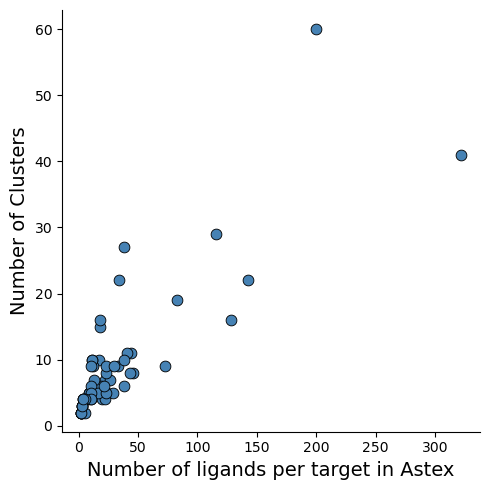

In [18]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=top_clusters_per_target,
    x='Ligands_in_Astex',
    y='Num_Ligands',
    s=60, color='steelblue', edgecolor='black'
)

plt.xlabel('Number of ligands per target in Astex', fontsize=14)
plt.ylabel('Number of Clusters', fontsize=14)

# Optional grid and layout tweaks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Gets clusters images

In [19]:
cluster_img = [('O14757', '104'),
               ('O76074', '26'),
               ('Q24451', '50')]

molsPerRow = 4

In [20]:
for uni, clus in cluster_img:

    mols = Chem.SmilesMolSupplier(f'../clusters_analysis/{uni}/{clus}/Matches_Smiles_Ligand_Name.txt', titleLine=False)

    mcs = ligands_per_cluster[(ligands_per_cluster.UniProt_ID == uni) & 
                              (ligands_per_cluster.Cluster == str(clus))].cluster_mcs.iloc[0]
    highlight_atom_lists = []

    to_draw = []

    for mol in mols:
        match = mol.GetSubstructMatch(Chem.MolFromSmarts(mcs))
        highlight_atom_lists.append(match if match else ())
        to_draw.append(mol)

    to_draw.append(Chem.MolFromSmarts(mcs))

    legends = [mol.GetPropsAsDict()['Column_2'] for mol in mols]
    legends.append('MCS')

    highlight_atom_lists.append(())

    # Draw grid with highlights
    img = Draw.MolsToGridImage(
        to_draw,
        molsPerRow=molsPerRow,
        subImgSize=(200,200),
        highlightAtomLists=highlight_atom_lists,
        legends=legends,
        useSVG=False)

    png = img.data
    type(png)


#     with open(f"../images/{uni}_{clus}_cluster.png", "wb+") as f:
#         f.write(png)

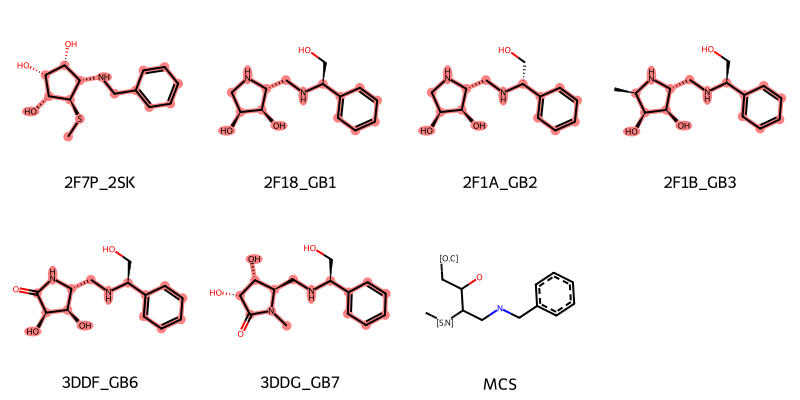

In [21]:
img